In this version(1.7): 
- Text processing
    - punctuations, insert space to the right only; done
    - inverse transform; done
- calculate perplexity during training from loss function.; done
- Training, fix number of token in a single epoch and pass the state of an epoch to the next epoch; done
- Penn Treebank http://www.nltk.org/howto/corpus.html. 
    - calculate train loss;  done
    - calculate valid loss/perplexity; done
    - calculate test loss/perplexity; done
    - replace \n with #endl; done
    - generator --> text into parts each part 2000 tokens.; done
    - check how to join perplexities from different epochs
    
    
In the upcoming versions:

- apply to other languages
    - Russian
    - Arabic
    - French
- think of the initial state of LSTM
- apply this network for char-level language modeling.
- label smoothing; Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna.
Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.




- https://www.quora.com/What-perplexities-do-state-of-the-art-language-models-achieve
-  paper RECURRENT NEURAL NETWORK REGULARIZATION,2015
    - the idea of this paper, apply dropout on non-recurrent connections only
- https://arxiv.org/pdf/1308.0850.pdf
- schedule inference
    - you have probability of using inference E
    - with chance E, use the output of the previous token instead of the ground truth label

For restoring previous check-point, I was forced to define the whole model in this notebook, rather that importing it from an external .py module.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from lib.dictionarymd import Dictionary
from IPython.display import clear_output
#from lib.textprocessingmd import convert_text
from lib.fileoperationmd import getFilesFromPath,readTxtFromFile,log,clearLog

In [2]:
def convert_text(text):
    return text.replace('\n','#endl')

In [3]:
from hyper import HyperParameters
hp=HyperParameters()
hp.DATAPATH='./data/ptb'
fname_train='ptb.train.txt'
fname_test ='ptb.test.txt'
fname_valid='ptb.valid.txt'
hp.batch_size=16
hp.LOGFILE="v1.7.log"

In [4]:
def loadData(path,fname):
    text=readTxtFromFile(path,fname)
    return [line for line in text.split('\n') if len(line)>10]

In [5]:
# --- Load articles - form dictionary - load dictionary
filenames=getFilesFromPath(hp.DATAPATH)
text=convert_text(readTxtFromFile(hp.DATAPATH,fname_train))

dictionary=Dictionary()
dictionary.make_vocab(text,hp.VOCPATH,hp.VOCFILE)

In [6]:
dictionary=Dictionary()
dictionary.load_vocab(hp.VOCPATH,hp.VOCFILE)
dataset=[]
trainset=convert_text(readTxtFromFile(hp.DATAPATH,fname_train))
validset=convert_text(readTxtFromFile(hp.DATAPATH,fname_valid))
testset=convert_text(readTxtFromFile(hp.DATAPATH,fname_test))

# Train

In [7]:
import tensorflow as tf
import numpy as np
from RNN_LSTM_LM import LSTMModel
#from helpers import batches_generator
from helpers import Beam
from helpers import beam_search,getBestCandidate

clearLog(hp.LOGPATH,hp.LOGFILE)
tf.reset_default_graph()

/home/zein/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def batches_generator(seq_len, text,dictionary,
                      shuffle=False, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    vec=dictionary.text2vec(text) 
    n_samples=len(vec)-1

    n_batches = n_samples // seq_len
    if allow_smaller_last_batch and n_samples % seq_len:
        n_batches += 1

    for k in range(n_batches):
        batch_start = k * seq_len
        batch_end = min((k + 1) * seq_len, n_samples)
        current_batch_size = batch_end - batch_start
        x = np.array([vec[batch_start:batch_end]])
        y = np.array([vec[batch_start+1:batch_end+1]])
            
        lengths = np.array([current_batch_size], dtype=np.int32)
        
        yield x, y, lengths, k+1, n_batches

In [9]:
model = LSTMModel(vocabulary_size=len(dictionary.word2idx)+4, n_tags=len(dictionary.word2idx)+4, embedding_dim=hp.embedding_dim,
                  n_hidden_rnn=hp.n_hidden_rnn, PAD_index=dictionary.word2idx['<PAD>'])
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#model_checkpoint = './model.chkpt'
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
def compute_perplexity(sess,model,text):
    sm=[]
    for x_batch, y_batch, lengths ,counter, total in batches_generator(500, text,dictionary):
        clear_output(wait=True)
        print("ُCompute validation: {}/{}, perp={}".format(counter,total,np.exp(np.mean(sm))))
        per=model.calculatePerplexity(sess,x_batch,y_batch, lengths)
        sm.append(per)
    return np.exp(np.mean(sm))

In [15]:
train=[]
validation=[]
test=[]

ُEboch 50/50.batch 1861/1860 
Epoch 49: <start> the meaning of life is restated to the u.s. market price price and repay the new post #endl refcorp said net fell slightly in the third consecutive month of the sale #endl a company 's new york said it has been the most active and a new agreement in a year earlier the u.s. unit #endl the company 's stock market has n't been to the company said it was in the first time in a year ago and the company #endl a spokesman declined #endl in new mexico said it expects a loss #endl the market said its stock closed #endl a new company has been the most active and in a year earlier #endl in new jersey new zealand the market 's largest u.s. auto giant the company is n't a major company said #endl the company had to be a major company to the company and a year in new england to; perplexity: train/validation 187.2996826171875/261.34881591796875


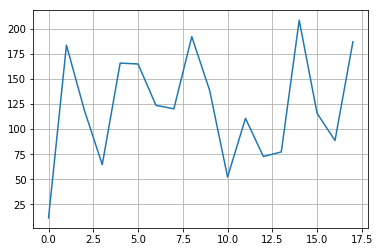

...training finished.


In [14]:
learning_rate=hp.learning_rate
print('Start training... \n')
results=""
start=25
for epoch in range(start,hp.n_epochs):
    validPerp=compute_perplexity(sess,model,validset)
    validation.append(validPerp)
    newc=getBestCandidate(sess,model,150,"the meaning of life is",dictionary)
    results="\nEpoch {}: {}; perplexity: validation {}".format(epoch,newc, validPerp)
    log(hp.LOGPATH,hp.LOGFILE,results)
    # For each epoch evaluate the model on train and validation data
    #print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(hp.n_epochs) + '-' * 20+results)
    
    perplexity=[]
    counter=0
    zero_state=True
    st_c,st_h=None,None
    # Train the model
    for x_batch, y_batch, lengths ,counter, total in batches_generator(500, trainset,dictionary,shuffle=True):
        clear_output(wait=True)
        
        counter=counter+1
        print("ُEboch {}/{}.batch {}/{} {}".format(epoch+1,hp.n_epochs,counter,total,results))
        plt.plot(perplexity)
        plt.grid()
        plt.show()
        loss,states=model.train_on_batch(sess, x_batch, y_batch, lengths, learning_rate, hp.dropout_keep_probability
                                        ,st_c,st_h, zero_state)
        st_c,st_h=states
        zero_state=False
        if counter%100==0:
            #validPerp=compute_perplexity(sess,model,validset)
            newc=getBestCandidate(sess,model,150,"the meaning of life is",dictionary)
            results="\nEpoch {}: {}; perplexity: train/validation {}/{}".format(epoch,newc, loss,validPerp)
            perplexity.append(loss)
    train.append(np.mean(perplexity))
    # Decaying the learning rate
    saver.save(sess, hp.MODEL_CHKPNT_PATH,global_step=epoch)
    if epoch>6:
        learning_rate = learning_rate / 1.61#hp.learning_rate_decay
    
print('...training finished.')

In [19]:
validation

[]

In [12]:
testPerp=compute_perplexity(sess,model,testset)
print("test perplexity is {}".format(testPerp))

ُCompute validation: 165/165, perp=186.86122131347656
test perplexity is 187.22975158691406


In [16]:
%time
# Generate text of 1000 words
full="""The pair are facing lengthy bans for the missed tests, including one on the eve of last year's Athens Olympics. 
They were set to learn their fate by the end of February, but late evidence from them has pushed the date back. "A decision is now expected by around mid-March," said one of their lawyers, Michalis Dimitrakopoulos."""
print(getBestCandidate(sess,model,1000,'I',dictionary))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
<start> <unk> needham kronor ark he says his mother 's own in the first eight minutes to be n't yet in a lot more the new jersey who was n't the most active #endl mr. noriega and mr. bush was n't a new company that he has a new proposal to the company #endl but the company said the u.s. attorney general manager is a new company that has n't seen a lot #endl in addition of mr. lawson and a new york stock markets and that it would be a new york firm #endl in the third market was a lot #endl but he says the new york mercantile futures markets are the most popular #endl the company also had to pay the company #endl but in new jersey the market said it was the most important #endl the new company 's stock market 's new york-based company has n't been in the company said it will continue #endl but that 's a lot to the company has a new bid #endl in the first quarter the new york-based stock is expected #endl but they had been to 

In [ ]:
#todo

# version2
# output
# normalize probabilities
# Evaluation

# char-level

# larger network

# Russian
# Arabic 
# French

# paper RECURRENT NEURAL NETWORK REGULARIZATION,2015